In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

In [2]:

%matplotlib inline

import os
import logging

from osgeo import gdal
import pygeoprocessing

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')

import pandas as pd

dem_loc='dem_90m_pnnl.tif'
veg_loc='binary_veg_90m.tif'

dem = gdal.Open(dem_loc)
veg = gdal.Open(veg_loc)

dem_map=dem.ReadAsArray()
veg_map=veg.ReadAsArray()
veg_map[veg_map < 0] = 0

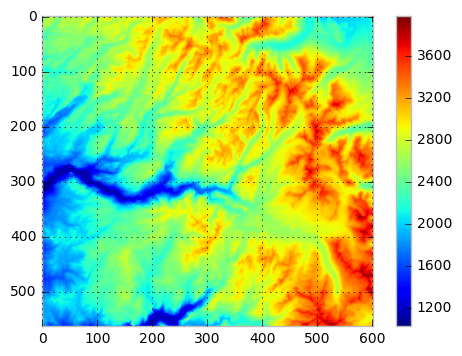

In [3]:
#plot DEM 
plt.imshow(dem_map)
plt.colorbar()


In [4]:
OUTPUT_DIR = './output/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

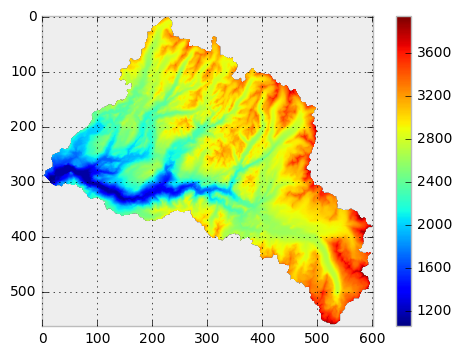

In [5]:
#load basin mask
from numpy import ma
_mask = gdal.Open('mask90m1.tif')
w_mask = _mask.ReadAsArray()
w_dem = ma.masked_where(w_mask == 0, dem_map)
plt.imshow(w_dem)
plt.colorbar()

In [6]:
OUTPUT_DIR = './output/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR);

slope_raster = os.path.join(OUTPUT_DIR, 'slope.tif')

pygeoprocessing.calculate_slope(
    dem_dataset_uri='dem_90m_pnnl.tif',
    slope_uri=slope_raster)

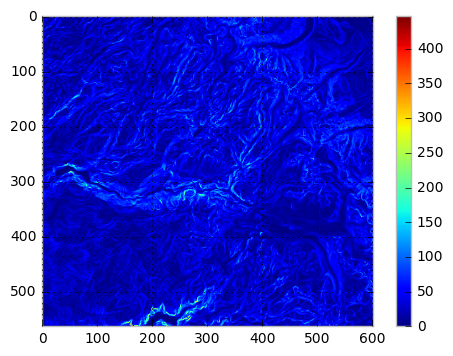

In [7]:
slope = gdal.Open(slope_raster)
slope_map=slope.ReadAsArray()

plt.imshow(slope_map)
plt.colorbar()

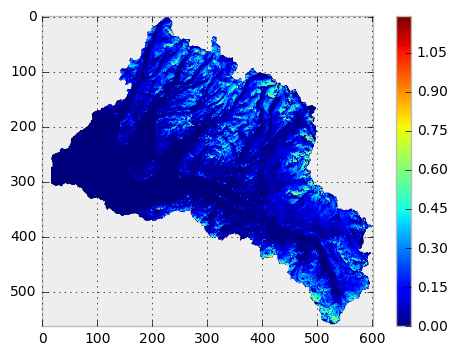

In [8]:
swe_loc='ASO_swe_day7.tif'
swe = gdal.Open(swe_loc)

swe_map=swe.ReadAsArray()

plt.imshow(swe_map)
plt.colorbar()

0...10...20...30...40...50...60...70...80...90...100 - done.


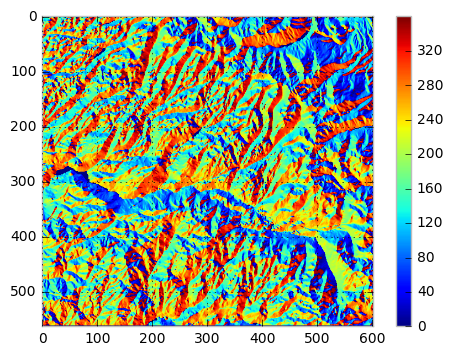

In [9]:
!gdaldem aspect 'dem_90m_pnnl.tif' 'aspect.tif' -trigonometric -zero_for_flat 

aspect_loc='aspect.tif'

aspect = gdal.Open(aspect_loc)


aspect_map=aspect.ReadAsArray()
plt.imshow(aspect_map)
plt.colorbar()

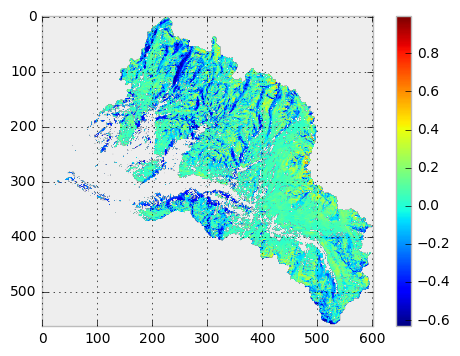

In [10]:
ds_model = gdal.Open('model_1202_swe_day7.tif')
swe_model = ds_model.ReadAsArray()
diff = swe_map - swe_model
diff[abs(diff) < 0.01] = np.nan
%matplotlib inline
plt.imshow(diff)
plt.colorbar()

1243

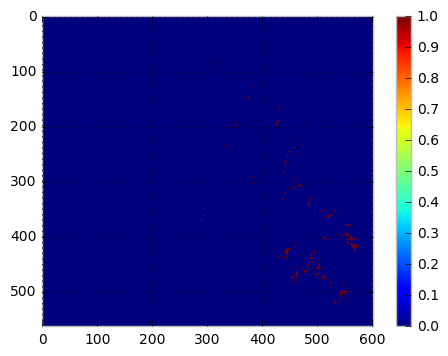

In [11]:

def _create_mask(swe_map, dem_map, slope_map, aspect_map,veg_map, swe_range, dem_range, slope_range, aspect_range, veg):
    # swe_map, dem_map, slope_map, veg_map, aspect_map : format - 2D-arrays
    # swe_range,elevation_range,slope_range, aspect_range: format [lower_boundary,upper_boundary]
    # veg should be1 for forested or 0 for non-forested

    # All blocks will be the same dimensions
    matching_pixels = (((swe_map > np.min(swe_range)) & (swe_map < np.max(swe_range))) &
                           ((dem_map > np.min(dem_range))& (dem_map < np.max(dem_range))) &
                           ((slope_map > np.min(slope_range)) & (slope_map < np.max(slope_range))) & 
                           ((aspect_map > np.min(aspect_range)) & (aspect_map < np.max(aspect_range))) & 
                           (veg_map == veg)) 
  
    out_nodata = -9999
    out_block = np.zeros((swe.RasterYSize,swe.RasterXSize))
    out_block =  matching_pixels 
    #out_block = out_block*1
    return out_block

mask1 = _create_mask(diff, dem_map, slope_map, aspect_map,veg_map,[-0.1,0.1], [3000,4000], [0,500],[1,180], 1)
#_create_mask(swe_range,elevation_range,slope_range,forest_or_nonforest)
plt.imshow(mask1)
plt.colorbar()
mask1.sum()

In [12]:
from numpy import ma  # masked arrays

In [39]:
def array_resh_pd(array_):
    size_col = array_.shape[0]*array_.shape[1]
    col = np.reshape(array_, size_col)
    a = pd.DataFrame(col)
    return a
# attn: aspect in gdal is diffrent than arcgis 
mask_forest = _create_mask(diff, dem_map, slope_map, aspect_map,veg_map,[-5, 5], [2500,4000], [40,500],[157,202], 1)
mask_no_forest = _create_mask(diff, dem_map, slope_map, aspect_map,veg_map,[-5, 5], [2500,4000], [40,500],[157,202], 0)
m_f = ma.masked_where(mask_forest == 0, diff)
m_nf = ma.masked_where(mask_no_forest == 0, diff)
m_ff = array_resh_pd(m_f)
m_nff = array_resh_pd(m_nf)

In [40]:
bp = pd.concat([m_ff, m_nff], axis = 1)
bp.columns = ['forest','no forest']

(-0.8, 0.8)

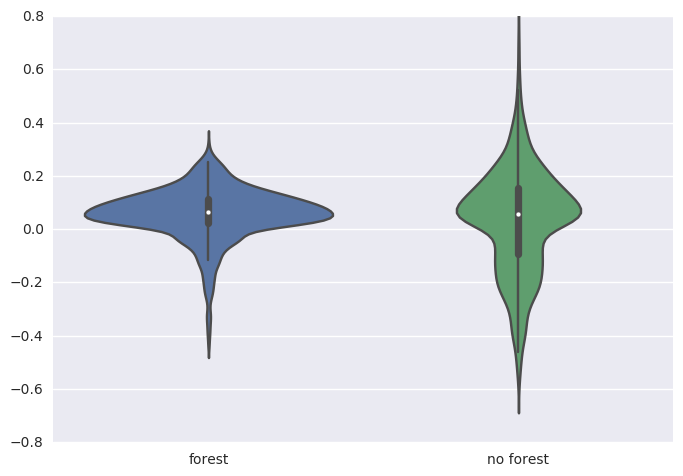

In [42]:
import seaborn as sns
sns.violinplot(bp);
plt.ylim(-0.8, 0.8)

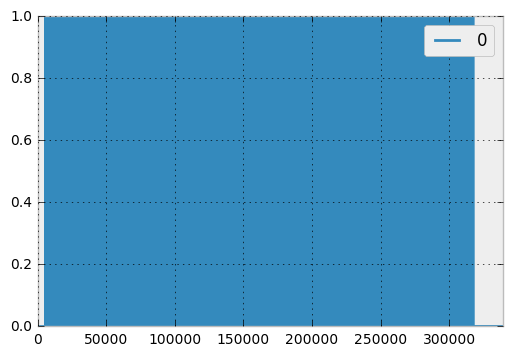

In [41]:
m_f.plot()
